# Transmission Spectra Model Visuals

Contribution visuals are an important tool for interpreting forward models and retrieved spectra. 

We differentiate here between two types of contribution visuals: (i) *spectral decomposition plots*, which highlight the impact of each chemical species on a spectrum; and (ii) *pressure contribution plots*, which highlight the atmospheric layers driving the formation of spectral features.

In this notebook, we will take HD 189733 b (a hot Jupiter) as an example forward model and analyse:

1. The spectral components of a transmission spectrum.
2. Where in the forward model atmosphere the spectrum forms.
3. Which pressure regions are probed at different wavelengths.

First, let's define our wavelength, planet, star, model, and opac objects.

All of these steps are the same as any forward model with POSEIDON.

In [1]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, define_model, \
                          wl_grid_constant_R, read_opacities
import numpy as np

#***** Model wavelength grid *****#

wl_min = 0.2    # Minimum wavelength (um)
wl_max = 12.0   # Maximum wavelength (um)
R = 5000        # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

In [2]:
#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J     # Planetary radius (m)
M_p = 1.129*M_J    # Planetary mass (kg)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p)

In [3]:
#***** Define stellar properties *****#

R_s = 0.751*R_Sun    # Stellar radius (m)
T_s = 5052           # Stellar effective temperature (K)
Met_s = 0.13         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

Here we will use a nominal chemical inventory for hot Jupiters: $\rm{CH_4}$, $\rm{CO}$, $\rm{CO_2}$, $\rm{HCN}$, $\rm{H_2 O}$, $\rm{K}$, $\rm{Na}$, and $\rm{NH_3}$. We also include an aerosol species that is predicted to form at the limb of HD 189733 b from GCM chemical disequilibrium predictions, namely enstatite ($\rm{MgSiO_3}$).

In [4]:
#***** Define model *****#

model_name_contribution_transmission = 'Contribution-Transmission'

bulk_species = ['H2', 'He']
param_species = ['CH4', 'CO', 'CO2', 'HCN', 'H2O','K','Na','NH3'] # <---- Nominal chemical inventory 
aerosol_species = ['MgSiO3'] # <--- Enstatite 

# Create the model object
model_contribution_transmission = define_model(model_name_contribution_transmission,
                                               bulk_species, param_species, 
                                               PT_profile = 'isotherm',
                                               cloud_model = 'Mie',cloud_type = 'slab',
                                               aerosol_species = aerosol_species)

Reading in database for aerosol cross sections...


In [5]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 500    # Same as prior range for T
T_fine_max = 1300    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-8   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1 

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_contribution_transmission, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CH4 done
CO done
CO2 done
HCN done
H2O done
K done
Na done
NH3 done
Opacity pre-interpolation complete.


Let's define our forward model atmosphere. Here I have pulled the retrieved values of an HD 189733 b transmission retrieval performed and reported in Mullens et al 2024.

In [6]:
from POSEIDON.core import make_atmosphere

R_p_ref                =   1.126 * R_J
T                      =   775.1
log_CH4                =   -8.56
log_CO                 =   -6.74
log_CO2                =   -6.90
log_HCN                =   -5.04
log_H2O                =   -3.94
log_K                  =   -8.85
log_Na                 =   -9.69
log_NH3                =   -9.08

log_P_top_slab_MgSiO3 =   -7.22
Delta_log_P_MgSiO3    =   2.97
log_r_m_MgSiO3        =   -1.34
log_X_MgSiO3          =   -12.5


PT_params = np.array([T])
log_X_params = np.array([log_CH4, log_CO, log_CO2, log_HCN, log_H2O, log_K, log_Na, log_NH3])
cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Make atmosphere 
atmosphere_contribution_transmission = make_atmosphere(planet, model_contribution_transmission, 
                                                       P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

## Spectral Decomposition

The spectral contribution function (`spectral_contribution`) found in contributions.py helps visualise the spectral components of specific species and their contribution to the spectrum. 

The function first computes all the hydrostatic equations assuming all the species are in the atmosphere. It then removes all the opacities of the species except for the one whose contribution is being visualised (i.e. the function uses the 'put-one-in' approach).

In the function, you list out which gas species you want in the `contribution_species_list`.

You then can list out `cloud_species_list` if you are using compositionally-specific aerosols (the function also requires that `cloud_contribution = True` in order to show cloud contributions).

If you are not using compositionally specific aerosols and instead are using a gray cloud deck or power law haze, you can set `cloud_total_contribution = True` to see the contribution of opaque decks, hazes, and the combined cloud opacity of combined clouds models (this setting was used in the [\"Clouds in Transmission Spectra\"](transmission_basic.html) tutorial).

If you want to see the baseline continuum opacity (set in this case by $\rm{H_2}$ and $\rm{He}$ collision induced absorption), set `bulk species = True`. 

The function returns the full spectrum (spectrum), the names of each spectrum computed, and the list of contribution spectra.

In [7]:
from POSEIDON.contributions import spectral_contribution

spectrum, spectrum_contribution_list_names, \
spectrum_contribution_list = spectral_contribution(planet, star, model_contribution_transmission, 
                                                   atmosphere_contribution_transmission, opac, wl,
                                                   contribution_species_list = ['CH4', 'CO', 'CO2', 'HCN', 'H2O', 'K', 'Na', 'NH3'], # <--- List gas species here 
                                                   cloud_species_list = ['MgSiO3'],     # <--- List aerosol species here 
                                                   bulk_species = True,                 # <--- To see bulk species contribution, set this True
                                                   cloud_contribution = True,           # <--- To see cloud or aerosol contribution, set this True
                                                   )

Once the function above has finished running, we can then plot our spectral contribution visual. 

To plot, use the `plot_spectral_contribution` function

In this function, you can define the line widths as well as colors

We recommend the full spectrum being a large line width, and then then the contribution spectra being smaller so that they can be seen overlaying the full spectrum. 

Below, we can see that $\rm{H_2 O}$, $\rm{HCN}$, $\rm{CO_2}$, and $\rm{MgSiO_3}$ contribute the most to the spectrum whereas other gas species do not.

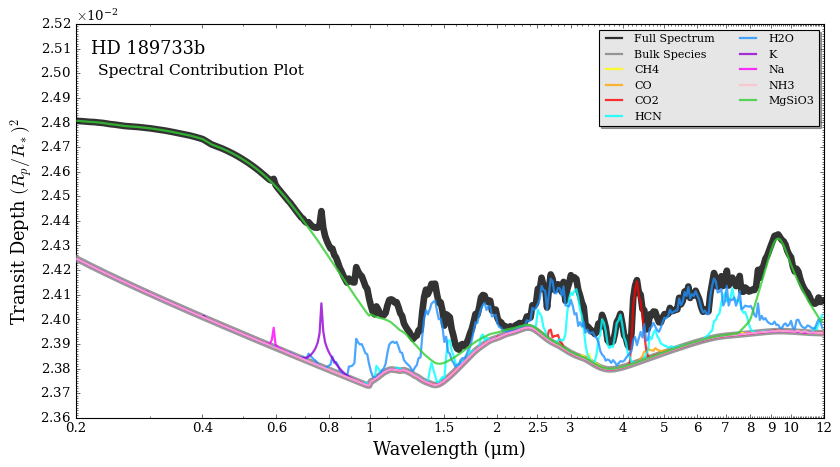

In [8]:
from POSEIDON.contributions import plot_spectral_contribution

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           line_widths = [6,6,2,2,2,2,2,2,2,2,2],
                           colour_list = ['black', 'gray', 'yellow','orange', 'red', 'aqua', 'dodgerblue',
                                          'darkviolet','magenta','pink','limegreen'],
                           save_fig = True)

## Pressure Contribution

The pressure contribution function goes layer by layer, removes an opacity source, and recomputes the spectrum, and takes the difference with the full spectrum. 

There is an option to do the total pressure contribution (which removes each layer's entire opacity source) or specific opacity sources.

Do note, however, that this process is slower than making a normal spectrum (since opacities must be calculated $N_{\rm{layers}}$ times).

We compute the total pressure contribution and water's pressure contribution below.

Since this is transmission, we expect all the contribution to be coming from high up in the atmosphere. 

To create the pressure contribution, run the `pressure_contribution` function below, which has has a similar set up to the spectral contribution function above. Here we have verbose turned on, which prints the layer number the function is on (the Pressure array has 100 layers), which is a good gauge for how long the spectrum will take to compute.

Contribution is an array with dimensions P vs wl vs contribution species. The norm is returned, but not used. The list names are used in plotting.

The plotting functions will return a normal contribution plot and, optionally, a log version.

In [9]:
from POSEIDON.contributions import pressure_contribution, plot_pressure_contribution

Contribution, norm, \
spectrum_contribution_list_names = pressure_contribution(planet, star, model_contribution_transmission, 
                                                         atmosphere_contribution_transmission, opac, wl,
                                                         spectrum_type = 'transmission',
                                                         bulk_species = False, 
                                                         cloud_contribution = False, 
                                                         total_pressure_contribution = True,
                                                         )

Progress: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


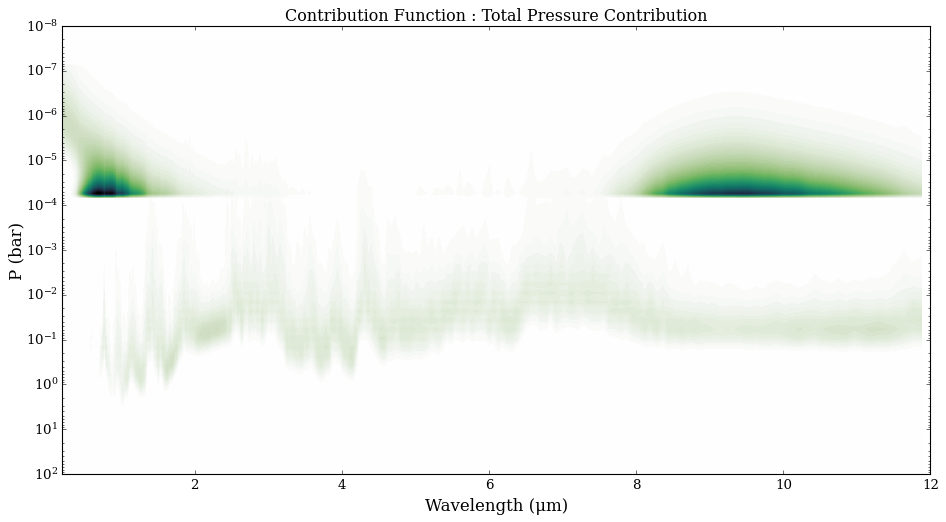

In [10]:
plot_pressure_contribution(wl, P, planet, Contribution, 
                           spectrum_contribution_list_names, R = 100,
                           show_log_plot = False, save_fig = True)

In the pressure contribution plot, we can really see the slab cloud in the upper atmosphere dominating the spectrum.

Now let's look at the contribution from water alone. 

In [11]:
from POSEIDON.contributions import pressure_contribution, plot_pressure_contribution

Contribution_water, norm_water, \
spectrum_contribution_list_names_water = pressure_contribution(planet, star, model_contribution_transmission, 
                                                               atmosphere_contribution_transmission, opac, wl,
                                                               spectrum_type = 'transmission',
                                                               contribution_species_list = ['H2O'],
                                                               bulk_species = False, 
                                                               cloud_contribution = False, 
                                                               total_pressure_contribution=False,
                                                               )

Progress: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


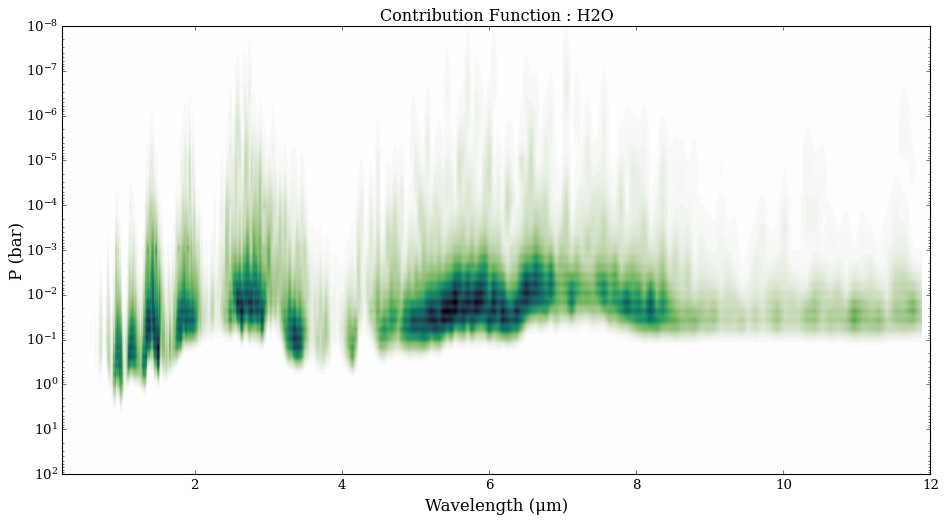

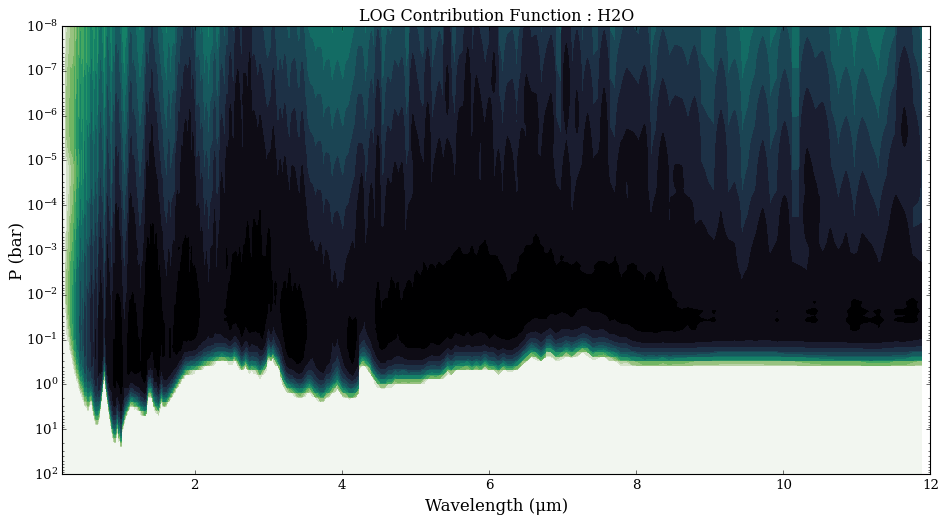

In [12]:
plot_pressure_contribution(wl, P, planet, Contribution_water, 
                           spectrum_contribution_list_names_water, R = 100,
                           show_log_plot = True, save_fig = True,
                           file_label = 'H2O')

## Photometric Contribution 

The pressure contribution function can also be integrated over a specific wavelength range to produce a 'photometric' pressure contribution function. 

We recommend wavelength bins of size $\Delta \lambda = 1$   um, to show which pressure layers contribute most over a given wavelength range.

The plotting function below will plot the binned contributions, then the total over all wavelengths.

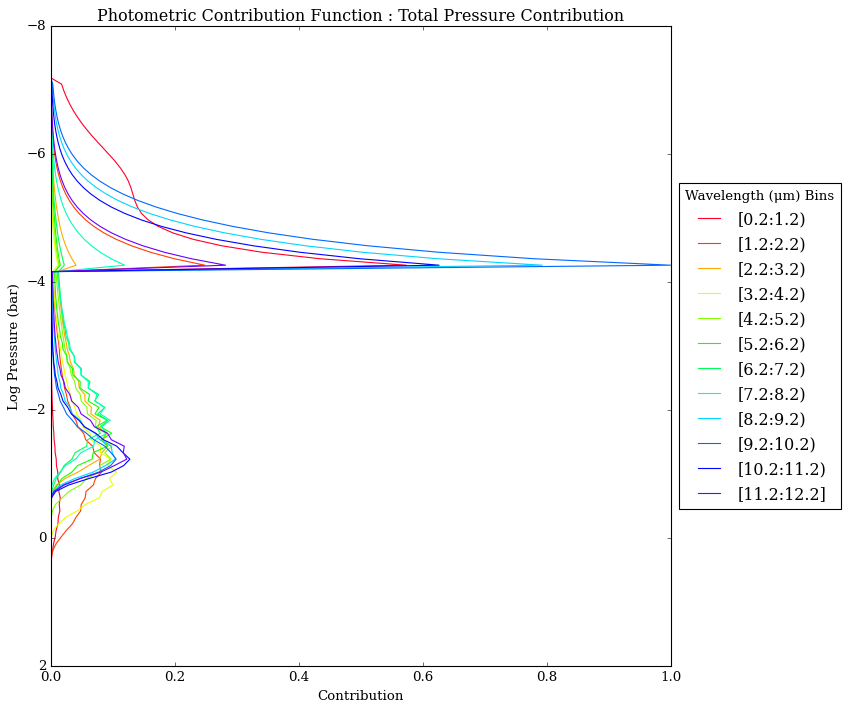

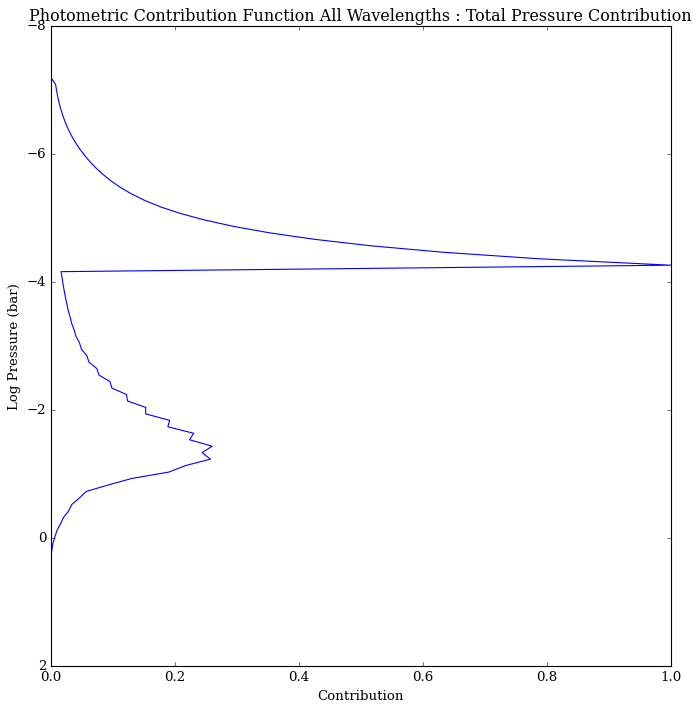

In [13]:
from POSEIDON.contributions import photometric_contribution_function, plot_photometric_contribution

photometric_contribution, \
photometric_all_wavelengths, bins = photometric_contribution_function(wl, P, Contribution, 
                                                                      spectrum_contribution_list_names,
                                                                      binsize = 1)

plot_photometric_contribution(P, planet, photometric_contribution, photometric_all_wavelengths,
                              spectrum_contribution_list_names, bins = bins,
                              save_fig = True)

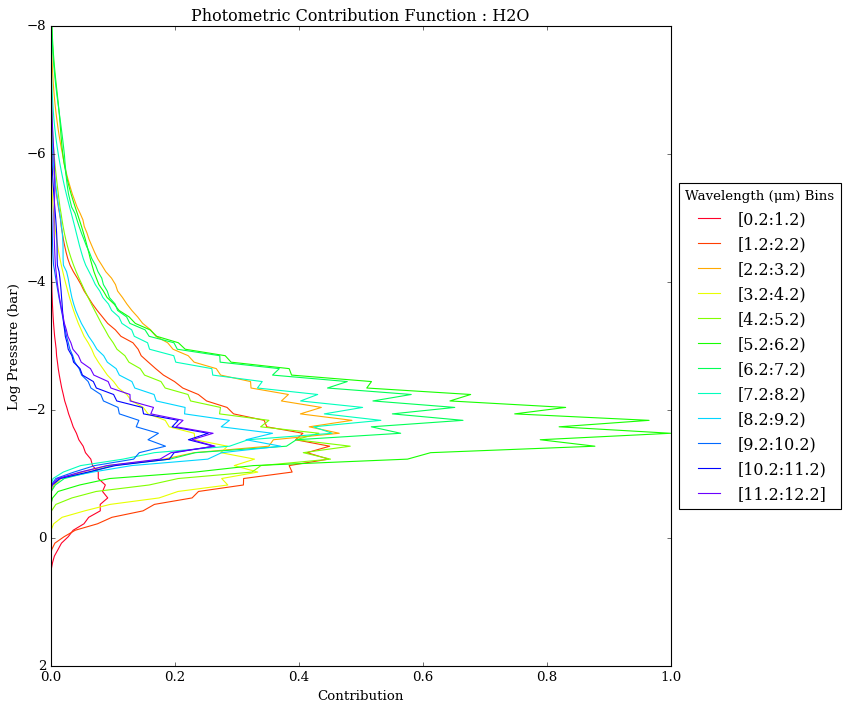

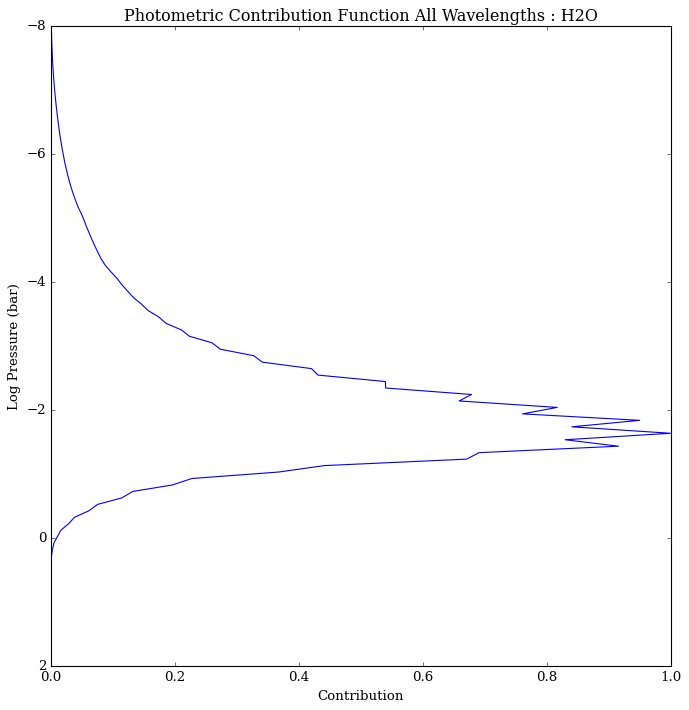

In [14]:
from POSEIDON.contributions import photometric_contribution_function, plot_photometric_contribution

photometric_contribution, \
photometric_all_wavelengths, bins = photometric_contribution_function(wl, P, Contribution_water, 
                                                                      spectrum_contribution_list_names_water,
                                                                      binsize = 1)

plot_photometric_contribution(P, planet, photometric_contribution, photometric_all_wavelengths,
                              spectrum_contribution_list_names_water, bins = bins,
                              save_fig = True, file_label = 'H2O')

There is an option to set the minimum wavelength as 0, so that the wavelength bins appear a bit nicer. 

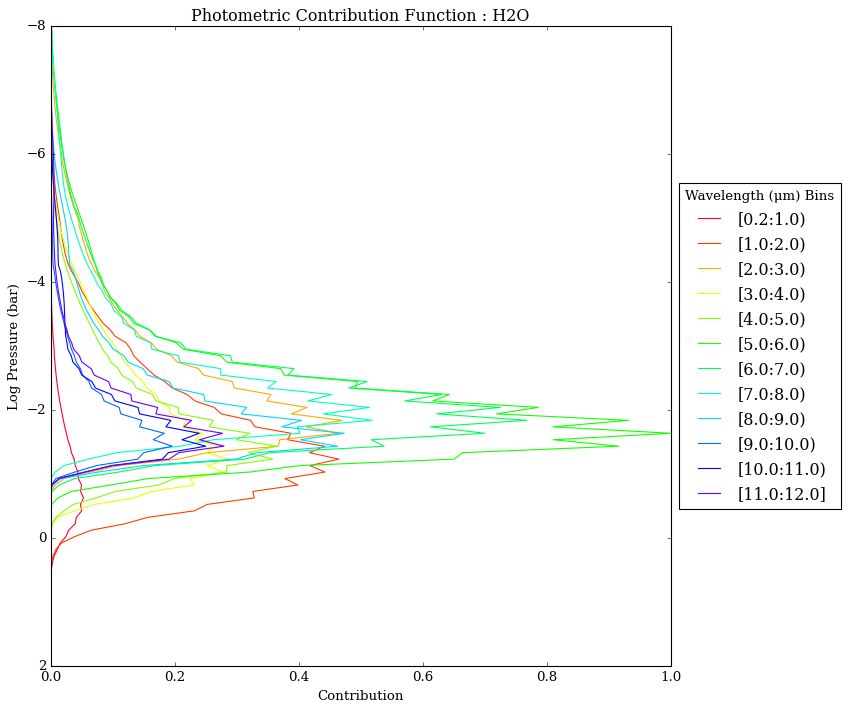

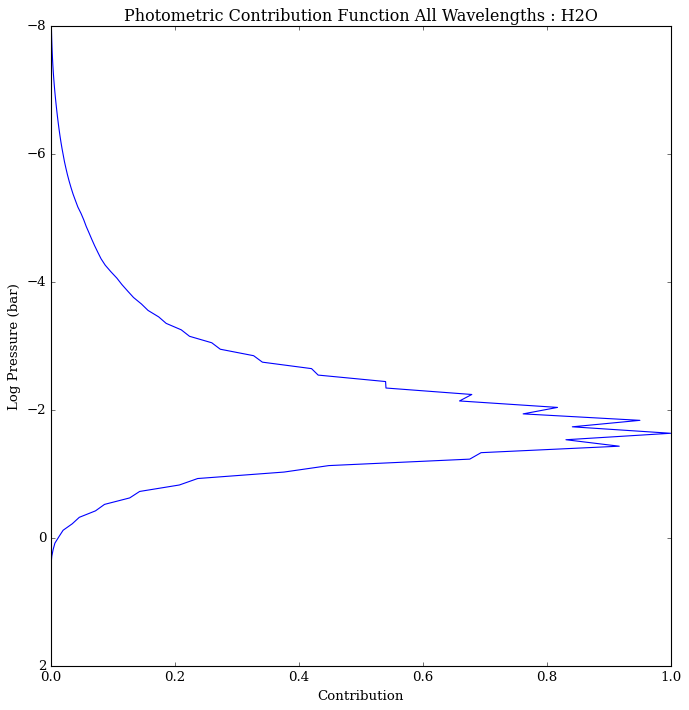

In [15]:
from POSEIDON.contributions import photometric_contribution_function, plot_photometric_contribution

photometric_contribution, \
photometric_all_wavelengths, bins = photometric_contribution_function(wl, P, Contribution_water, 
                                                                      spectrum_contribution_list_names_water,
                                                                      binsize = 1,
                                                                      treat_wlmin_as_zero = True)

plot_photometric_contribution(P, planet, photometric_contribution, photometric_all_wavelengths,
                              spectrum_contribution_list_names_water, bins = bins)